# Example: word and phoneme classification

Classify phonemes using data augmentation and mel spectrograms.

The previous attempt get around 62% accouracy on phoneme classification with:
* No data augmentation
* Curriculum learning like strategy (train on most frequent classes first and less frequent after)
* Validation set mate of random split of TRAIN+TEST folder 

Actually the last point was very important in terms of model generalization because i this notebook we're going t use the "TEST" (hold out) as validation set.  

In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *

Import FastAI Audio modules here:

In [79]:
from exp.nb_AudioCommon import *
from exp.nb_DataBlock import *
from exp.nb_DataAugmentation import *

### Other library imports

If this cell fails, you probably haven't installed the correct system/Python dependencies. You might need to re-run the "System setup" cell again.

In [4]:
import torch
from pdb import set_trace
from IPython.display import Audio
from pydub import AudioSegment, silence
import torchaudio
from torchaudio import transforms
import pandas as pd

In [5]:
#Options
pd.set_option('display.max_colwidth', -1)

## Preparing the data

We're going to do **phoneme classification** using the TIMIT dataset.

The copyright on TIMIT isn't clear, and the data is hard to download, so we assume that the user has access to this dataset.

**IMPORTANT:** the dataset should be located in the standard fast.ai location:
> $HOME/.fastai/data/timit

In [6]:
path = getFastAiWorkingDirectory('timit')

Working directory: /home/ste/.fastai/data/timit


### What's inside:
*All these informations are taken from README file inside the dataset*

    The dialect regions are:
         dr1:  New England
         dr2:  Northern
         dr3:  North Midland
         dr4:  South Midland
         dr5:  Southern
         dr6:  New York City
         dr7:  Western
         dr8:  Army Brat (moved around)     
     
      Dialect
      Region(dr)    #Male    #Female    Total
      ----------  --------- ---------  ----------
         1         31 (63%)  18 (27%)   49 (8%)  
         2         71 (70%)  31 (30%)  102 (16%) 
         3         79 (67%)  23 (23%)  102 (16%) 
         4         69 (69%)  31 (31%)  100 (16%) 
         5         62 (63%)  36 (37%)   98 (16%) 
         6         30 (65%)  16 (35%)   46 (7%) 
         7         74 (74%)  26 (26%)  100 (16%) 
         8         22 (67%)  11 (33%)   33 (5%)
       ------     --------- ---------  ---------- 
         8        438 (70%) 192 (30%)  630 (100%)
         
      
      Sentence Type   #Sentences   #Speakers   Total   #Sentences/Speaker
      -------------   ----------   ---------   -----   ------------------
      Dialect (SA)          2         630       1260           2
      Compact (SX)        450           7       3150           5
      Diverse (SI)       1890           1       1890           3
      -------------   ----------   ---------   -----    ----------------
      Total              2342                   6300          10


### File Format description:

    /<CORPUS>/<USAGE>/<DIALECT>/<SEX><SPEAKER_ID>/<SENTENCE_ID>.<FILE_TYPE>

     where,

     CORPUS :== timit
     USAGE :== train | test
     DIALECT :== dr1 | dr2 | dr3 | dr4 | dr5 | dr6 | dr7 | dr8 
                 (see Table 1 for dialect code description)
     SEX :== m | f
     SPEAKER_ID :== <INITIALS><DIGIT>
          
          where, 
          INITIALS :== speaker initials, 3 letters
          DIGIT :== number 0-9 to differentiate speakers with identical
                    initials
                              
     SENTENCE_ID :== <TEXT_TYPE><SENTENCE_NUMBER>
          
          where,
              
          TEXT_TYPE :== sa | si | sx
                        (see Section 2 for sentence text type description)
          SENTENCE_NUMBER :== 1 ... 2342
                    
     FILE_TYPE :== wav | txt | wrd | phn
                   (see Table 5 for file type description)

Examples:
     /timit/train/dr1/fcjf0/sa1.wav
                         
     (TIMIT corpus, training set, dialect region 1, female speaker, 
      speaker-ID "cjf0", sentence text "sa1", speech waveform file)
      

      /timit/test/df5/mbpm0/sx407.phn
      
      (TIMIT corpus, test set, dialect region 5, male speaker, speaker-ID
       "bpm0", sentence text "sx407", phonetic transcription file)
      

### Take a look at the data

In [7]:
path.ls()

[PosixPath('/home/ste/.fastai/data/timit/TRAIN'),
 PosixPath('/home/ste/.fastai/data/timit/TEST'),
 PosixPath('/home/ste/.fastai/data/timit/DOC'),
 PosixPath('/home/ste/.fastai/data/timit/README.DOC'),
 PosixPath('/home/ste/.fastai/data/timit/models')]

In [8]:
#!cat /home/ste/.fastai/data/timit/README.DOC

The dataset contains 
* TRAIN: both X and Y data
* TEST: both X and Y data

**IMPORTANT**: the dataset provide it's own TEST set with labels.
According to the *file description* we've to understand if the test set is actually an **HOLD OUT** set (unseen speaker/dialect) or not.

### Sample format

All the timit samples are provided with the following structure:

* WAV: The actual sound 
* WRD: Word annotation
* PHN: Phoneme annotation 
* TXT: The complete transcription of the file

In [9]:
baseSample = str(path) + '/TRAIN/DR5/MBGT0/SA2'

In [10]:
# Audio file
baseSample_ad = AudioData.load(baseSample + '.WAV')
display(AudioItem(baseSample_ad))

AudioItem REPRESENTATION

In [11]:
# Phoneme file
baseSample_phn = pd.read_csv(baseSample + '.PHN', delimiter=' ', header=None, names=['start','end','phn'])
baseSample_phn.head()

,start,end,phn
0,0,3750,h#
1,3750,4060,d
2,4060,5960,ow
3,5960,6649,nx
4,6649,9566,ae


In [12]:
# Phoneme file
baseSample_wrd = pd.read_csv(baseSample + '.WRD', delimiter=' ', header=None, names=['start','end','wrd'])
baseSample_wrd.head()

,start,end,wrd
0,3750,6649,don't
1,6649,11553,ask
2,11553,12960,me
3,12960,14360,to
4,14360,21013,carry


In [13]:
# Phoneme file
with open(baseSample + '.TXT') as f:
    lines = f.readlines()
    print(lines)

["0 47514 Don't ask me to carry an oily rag like that.\n"]


### Parsing the data

In [14]:
def extractInformationsFromAbsolutePath(s: str):
    items = list(filter(lambda x: len(x)>0,s.split('/')))
    USAGE = items[0]
    DIALECT = items[1]
    SEX = items[2][0]
    SPEAKER_ID = items[2][1:]
    SENTENCE_ID = items[3]
    return USAGE, DIALECT, SEX, SPEAKER_ID, SENTENCE_ID
    
def test_extractInformationsFromAbsolutePath():
    USAGE, DIALECT, SEX, SPEAKER_ID, SENTENCE_ID = extractInformationsFromAbsolutePath('/TRAIN/DR7/MPAR0/SI2206')
    assert 'TRAIN'==USAGE
    assert 'DR7'==DIALECT
    assert 'M'==SEX
    assert 'PAR0'==SPEAKER_ID
    assert 'SI2206'==SENTENCE_ID
    print('TEST PASED')

test_extractInformationsFromAbsolutePath()

TEST PASED


In [15]:
def extractTimitDatasetInformation(path):
    '''Put in a dataframe all the information about samples'''
    import glob
    files = glob.glob(str(path)+ '/**/*.WAV', recursive=True)
    ret = pd.DataFrame(files, columns=['relPath'])
    #Remove path and extension
    ret['relPath'] = ret['relPath'].apply(lambda x: x.replace(str(path),'').replace('.WAV',''))

    def extractIntoSeries(s):
        USAGE, DIALECT, SEX, SPEAKER_ID, SENTENCE_ID = extractInformationsFromAbsolutePath(s)
        return pd.Series({
            'USAGE': USAGE,
            'DIALECT': DIALECT,
            'SEX': SEX,
            'SPEAKER_ID': SPEAKER_ID,
            'SENTENCE_ID': SENTENCE_ID,
            'IDX': SEX + SPEAKER_ID + ':' + SENTENCE_ID})

    #IMPORTANT: Apply multiple transformations at one
    ret = ret.merge(ret['relPath'].apply(lambda s: extractIntoSeries(s)), left_index=True, right_index=True)    
    ret = ret.set_index(['IDX']) # Add index
    return ret
                
all_files_df = extractTimitDatasetInformation(path)
all_files_df.head()

,relPath,USAGE,DIALECT,SEX,SPEAKER_ID,SENTENCE_ID
IDX,,,,,,
MPAR0:SI2206,/TRAIN/DR7/MPAR0/SI2206,TRAIN,DR7,M,PAR0,SI2206
MPAR0:SX316,/TRAIN/DR7/MPAR0/SX316,TRAIN,DR7,M,PAR0,SX316
MPAR0:SI1576,/TRAIN/DR7/MPAR0/SI1576,TRAIN,DR7,M,PAR0,SI1576
MPAR0:SA1,/TRAIN/DR7/MPAR0/SA1,TRAIN,DR7,M,PAR0,SA1
MPAR0:SX46,/TRAIN/DR7/MPAR0/SX46,TRAIN,DR7,M,PAR0,SX46


In [16]:
print(f'Number of files: {len(all_files_df)}')

Number of files: 6300


### Data Overview  

In [17]:
#Number of files in train and test set
all_files_df.groupby(['USAGE'])['relPath'].count()

USAGE
TEST     1680
TRAIN    4620
Name: relPath, dtype: int64

### Determine if the test set is an HOLD OUT set.
We'll check if in the TEST there are unseen data. 

In [18]:
#A,B contains the tuples of SEX','SPEAKER_ID','SENTENCE_ID
A = list(all_files_df[all_files_df['USAGE']=='TRAIN'].groupby(['SEX','SPEAKER_ID','SENTENCE_ID']).indices.keys())
B = list(all_files_df[all_files_df['USAGE']=='TEST'].groupby(['SEX','SPEAKER_ID','SENTENCE_ID']).indices.keys())

In [19]:
nItemsBinA = len(list(filter(lambda x: x is True, [item in A for item in B])))
print(f'Number of items in B present in A: {nItemsBinA}')

Number of items in B present in A: 0


**IMPORTANT**: yes, this is an **hold out set**, so let's use it as validation set.

# Word classification

## Create data bunch

In [20]:
def process_phn_file(idx:str, phn_file, sig, sr, ext, delimiter=' ')->pd.DataFrame:
    df = pd.read_csv(phn_file, delimiter=delimiter, header=None)
    df.columns = ['START', 'END', ext]
    df['SIG'] = df.apply(lambda x : sig[x['START']: x['END']], axis=1)
    df['SR'] = sr
    df['IDX'] = idx
    df['IDXN'] = pd.Series(map(lambda x: idx+':'+str(x), range(len(df))))   
    df = df.set_index(['IDXN'])
    return df

In [21]:
def extractItems(path, idx, relativePath, ext, verbose=False)->pd.DataFrame:
    base_path = str(path) + relativePath
    wav_file = base_path + ".WAV"
    wav_exists = os.path.isfile(wav_file)
    if verbose: print(wav_file, f'\tExists: {wav_exists}')
    #Sanity check
    if not wav_exists: return none
    #Proceed
    sigTwoChannels,sr = torchaudio.load(wav_file)
    sig = sigTwoChannels[0] # MONO NO STEREO - convert to "one dimension"
    phn_file = base_path + '.' + ext
            
    ret = process_phn_file(idx, phn_file, sig, sr, ext, delimiter=' ')
    
    return ret

#    sig,sr = torchaudio.load(str(phn_file.replace('PHN', 'WAV')))
#    df = process_phn_file(phn_file, sig, sr, delimiter=' ')
#    df['Source'] = phn_file
#    final = final.append(df)
            
def test_extractItems_PHN():
    row = all_files_df.iloc[0]
    ret_df = extractItems(path, row.name, row['relPath'], 'PHN', verbose=True)
    display(ret_df.head(2))
    print(f'Number of rows: {len(ret_df)}')
    assert 54==len(ret_df)
    print('TEST DONE')

test_extractItems_PHN()

/home/ste/.fastai/data/timit/TRAIN/DR7/MPAR0/SI2206.WAV 	Exists: True


,START,END,PHN,SIG,SR,IDX
IDXN,,,,,,
MPAR0:SI2206:0,0,3212,h#,"[tensor(3.0518e-05), tensor(0.), tensor(3.0518e-05), tensor(6.1035e-05), tensor(0.0001), tensor(-6.1035e-05), tensor(0.0001), tensor(0.), tensor(-9.1553e-05), tensor(3.0518e-05), tensor(0.0001), tensor(6.1035e-05), tensor(9.1553e-05), tensor(6.1035e-05), tensor(0.0001), tensor(-3.0518e-05), tensor(3.0518e-05), tensor(3.0518e-05), tensor(0.0001), tensor(0.0002), tensor(9.1553e-05), tensor(9.1553e-05), tensor(0.), tensor(0.0001), tensor(6.1035e-05), tensor(6.1035e-05), tensor(3.0518e-05), tensor(0.0002), tensor(6.1035e-05), tensor(0.0001), tensor(3.0518e-05), tensor(0.0001), tensor(3.0518e-05), tensor(6.1035e-05), tensor(3.0518e-05), tensor(9.1553e-05), tensor(9.1553e-05), tensor(-3.0518e-05), tensor(0.0002), tensor(0.0001), tensor(0.0002), tensor(-3.0518e-05), tensor(0.0001), tensor(6.1035e-05), tensor(0.0002), tensor(9.1553e-05), tensor(9.1553e-05), tensor(9.1553e-05), tensor(0.), tensor(0.), tensor(3.0518e-05), tensor(6.1035e-05), tensor(0.), tensor(3.0518e-05), tensor(0.), tensor(3.0518e-05), tensor(6.1035e-05), tensor(3.0518e-05), tensor(6.1035e-05), tensor(0.), tensor(0.0001), tensor(9.1553e-05), tensor(9.1553e-05), tensor(3.0518e-05), tensor(0.0002), tensor(6.1035e-05), tensor(9.1553e-05), tensor(0.0002), tensor(0.0001), tensor(9.1553e-05), tensor(9.1553e-05), tensor(6.1035e-05), tensor(0.0002), tensor(9.1553e-05), tensor(0.0001), tensor(0.0002), tensor(9.1553e-05), tensor(0.0002), tensor(0.0002), tensor(0.0001), tensor(0.0002), tensor(9.1553e-05), tensor(9.1553e-05), tensor(9.1553e-05), tensor(0.0001), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(6.1035e-05), tensor(0.0001), tensor(9.1553e-05), tensor(9.1553e-05), tensor(9.1553e-05), tensor(0.0001), tensor(9.1553e-05), tensor(0.0001), tensor(0.0002), tensor(3.0518e-05), tensor(0.0001), tensor(9.1553e-05), ...]",16000,MPAR0:SI2206
MPAR0:SI2206:1,3212,3648,n,"[tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0004), tensor(0.0004), tensor(0.0004), tensor(0.0005), tensor(0.0004), tensor(0.0003), tensor(0.0003), tensor(0.0002), tensor(-0.0003), tensor(0.0008), tensor(0.0011), tensor(-0.0012), tensor(0.0018), tensor(-0.0004), tensor(0.0007), tensor(0.0002), tensor(3.0518e-05), tensor(9.1553e-05), tensor(0.0009), tensor(-9.1553e-05), tensor(0.0006), tensor(0.), tensor(0.0011), tensor(9.1553e-05), tensor(0.0008), tensor(0.0005), tensor(0.0010), tensor(0.0009), tensor(0.0005), tensor(0.0012), tensor(0.0009), tensor(0.0014), tensor(0.0008), tensor(0.0011), tensor(0.0008), tensor(0.0008), tensor(0.0007), tensor(0.0006), tensor(0.0009), tensor(0.0005), tensor(0.0005), tensor(0.0003), tensor(0.0002), tensor(0.0003), tensor(0.0002), tensor(0.0002), tensor(6.1035e-05), tensor(-0.0002), tensor(-0.0004), tensor(-0.0003), tensor(-0.0004), tensor(-0.0005), tensor(-0.0007), tensor(-0.0010), tensor(-0.0013), tensor(-0.0013), tensor(-0.0013), tensor(-0.0014), tensor(-0.0016), tensor(-0.0019), tensor(-0.0022), tensor(-0.0023), tensor(-0.0025), tensor(-0.0025), tensor(-0.0026), tensor(-0.0028), tensor(-0.0028), tensor(-0.0030), tensor(-0.0029), tensor(-0.0028), tensor(-0.0027), tensor(-0.0026), tensor(-0.0028), tensor(-0.0028), tensor(-0.0028), tensor(-0.0025), tensor(-0.0020), tensor(-0.0017), tensor(-0.0016), tensor(-0.0016), tensor(-0.0017), tensor(-0.0016), tensor(-0.0016), tensor(-0.0011), tensor(-0.0011), tensor(-0.0009), tensor(-0.0011), tensor(-0.0013), tensor(-0.0013), tensor(-0.0015), tensor(-0.0012), tensor(-0.0008), tensor(-0.0005), tensor(0.0002), tensor(0.0006), tensor(0.0016), tensor(0.0021), ...]",16000,MPAR0:SI2206


Number of rows: 54
TEST DONE


In [22]:
def test_extractItems_WRD():
    row = all_files_df.iloc[0]
    ret_df = extractItems(path, row.name, row['relPath'], 'WRD', verbose=True)
    display(ret_df.head(1))
    print(f'Number of rows: {len(ret_df)}')
    assert 14==len(ret_df)
    print('TEST DONE')

test_extractItems_WRD()

/home/ste/.fastai/data/timit/TRAIN/DR7/MPAR0/SI2206.WAV 	Exists: True


,START,END,WRD,SIG,SR,IDX
IDXN,,,,,,
MPAR0:SI2206:0,3212,6050,not,"[tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0004), tensor(0.0004), tensor(0.0004), tensor(0.0005), tensor(0.0004), tensor(0.0003), tensor(0.0003), tensor(0.0002), tensor(-0.0003), tensor(0.0008), tensor(0.0011), tensor(-0.0012), tensor(0.0018), tensor(-0.0004), tensor(0.0007), tensor(0.0002), tensor(3.0518e-05), tensor(9.1553e-05), tensor(0.0009), tensor(-9.1553e-05), tensor(0.0006), tensor(0.), tensor(0.0011), tensor(9.1553e-05), tensor(0.0008), tensor(0.0005), tensor(0.0010), tensor(0.0009), tensor(0.0005), tensor(0.0012), tensor(0.0009), tensor(0.0014), tensor(0.0008), tensor(0.0011), tensor(0.0008), tensor(0.0008), tensor(0.0007), tensor(0.0006), tensor(0.0009), tensor(0.0005), tensor(0.0005), tensor(0.0003), tensor(0.0002), tensor(0.0003), tensor(0.0002), tensor(0.0002), tensor(6.1035e-05), tensor(-0.0002), tensor(-0.0004), tensor(-0.0003), tensor(-0.0004), tensor(-0.0005), tensor(-0.0007), tensor(-0.0010), tensor(-0.0013), tensor(-0.0013), tensor(-0.0013), tensor(-0.0014), tensor(-0.0016), tensor(-0.0019), tensor(-0.0022), tensor(-0.0023), tensor(-0.0025), tensor(-0.0025), tensor(-0.0026), tensor(-0.0028), tensor(-0.0028), tensor(-0.0030), tensor(-0.0029), tensor(-0.0028), tensor(-0.0027), tensor(-0.0026), tensor(-0.0028), tensor(-0.0028), tensor(-0.0028), tensor(-0.0025), tensor(-0.0020), tensor(-0.0017), tensor(-0.0016), tensor(-0.0016), tensor(-0.0017), tensor(-0.0016), tensor(-0.0016), tensor(-0.0011), tensor(-0.0011), tensor(-0.0009), tensor(-0.0011), tensor(-0.0013), tensor(-0.0013), tensor(-0.0015), tensor(-0.0012), tensor(-0.0008), tensor(-0.0005), tensor(0.0002), tensor(0.0006), tensor(0.0016), tensor(0.0021), ...]",16000,MPAR0:SI2206


Number of rows: 14
TEST DONE


In [23]:
all_files_df.head(2)

,relPath,USAGE,DIALECT,SEX,SPEAKER_ID,SENTENCE_ID
IDX,,,,,,
MPAR0:SI2206,/TRAIN/DR7/MPAR0/SI2206,TRAIN,DR7,M,PAR0,SI2206
MPAR0:SX316,/TRAIN/DR7/MPAR0/SX316,TRAIN,DR7,M,PAR0,SX316


In [24]:
all_files_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6300 entries, MPAR0:SI2206 to FJEM0:SX184
Data columns (total 6 columns):
relPath        6300 non-null object
USAGE          6300 non-null object
DIALECT        6300 non-null object
SEX            6300 non-null object
SPEAKER_ID     6300 non-null object
SENTENCE_ID    6300 non-null object
dtypes: object(6)
memory usage: 344.5+ KB


In [25]:
def createItemsDataFrame(path, files_df, ext):
    ret = pd.DataFrame()
    for i,row in files_df.iterrows():
        tmp_df = extractItems(path, row.name, row['relPath'], ext)
        ret = ret.append(tmp_df)
        #print(len(ret))
#    ret = files_df.apply(lambda row: ret.append(extractWords(path, row.name, row['relPath']), ignore_index=True), axis=1)
#    files_df.apply(lambda row: print(row), axis=1)
    return ret

def test_createItemsDataFrame():
    tdf = createItemsDataFrame(path, all_files_df.head(10), 'WRD')
    print(f'Rows: {len(tdf)}')
    tdf.info()
    assert 86==len(tdf)

test_createItemsDataFrame()

Rows: 86
<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, MPAR0:SI2206:0 to MPAR0:SI946:8
Data columns (total 6 columns):
START    86 non-null int64
END      86 non-null int64
WRD      86 non-null object
SIG      86 non-null object
SR       86 non-null int64
IDX      86 non-null object
dtypes: int64(3), object(3)
memory usage: 4.7+ KB


In [26]:
%time all_words_df = createItemsDataFrame(path, all_files_df, 'WRD')
all_words_df.info()

CPU times: user 7min 17s, sys: 7.03 s, total: 7min 24s
Wall time: 1min 14s
<class 'pandas.core.frame.DataFrame'>
Index: 54387 entries, MPAR0:SI2206:0 to FJEM0:SX184:6
Data columns (total 6 columns):
START    54387 non-null int64
END      54387 non-null int64
WRD      54387 non-null object
SIG      54387 non-null object
SR       54387 non-null int64
IDX      54387 non-null object
dtypes: int64(3), object(3)
memory usage: 2.9+ MB


In [30]:
# Store pre computed result...
# WARNING: this is a 11GB file..
#all_words_df.to_pickle(str(path/'models/all_words_df.pkl'))

In [31]:
#all_words_df = pd.read_pickle(str(path/'models/all_words_df.pkl'))

In [32]:
print(f'Words count: {len(all_words_df)}')

Words count: 54387


In [33]:
all_words_df.head(2)

,START,END,WRD,SIG,SR,IDX
IDXN,,,,,,
MPAR0:SI2206:0,3212,6050,not,"[tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0004), tensor(0.0004), tensor(0.0004), tensor(0.0005), tensor(0.0004), tensor(0.0003), tensor(0.0003), tensor(0.0002), tensor(-0.0003), tensor(0.0008), tensor(0.0011), tensor(-0.0012), tensor(0.0018), tensor(-0.0004), tensor(0.0007), tensor(0.0002), tensor(3.0518e-05), tensor(9.1553e-05), tensor(0.0009), tensor(-9.1553e-05), tensor(0.0006), tensor(0.), tensor(0.0011), tensor(9.1553e-05), tensor(0.0008), tensor(0.0005), tensor(0.0010), tensor(0.0009), tensor(0.0005), tensor(0.0012), tensor(0.0009), tensor(0.0014), tensor(0.0008), tensor(0.0011), tensor(0.0008), tensor(0.0008), tensor(0.0007), tensor(0.0006), tensor(0.0009), tensor(0.0005), tensor(0.0005), tensor(0.0003), tensor(0.0002), tensor(0.0003), tensor(0.0002), tensor(0.0002), tensor(6.1035e-05), tensor(-0.0002), tensor(-0.0004), tensor(-0.0003), tensor(-0.0004), tensor(-0.0005), tensor(-0.0007), tensor(-0.0010), tensor(-0.0013), tensor(-0.0013), tensor(-0.0013), tensor(-0.0014), tensor(-0.0016), tensor(-0.0019), tensor(-0.0022), tensor(-0.0023), tensor(-0.0025), tensor(-0.0025), tensor(-0.0026), tensor(-0.0028), tensor(-0.0028), tensor(-0.0030), tensor(-0.0029), tensor(-0.0028), tensor(-0.0027), tensor(-0.0026), tensor(-0.0028), tensor(-0.0028), tensor(-0.0028), tensor(-0.0025), tensor(-0.0020), tensor(-0.0017), tensor(-0.0016), tensor(-0.0016), tensor(-0.0017), tensor(-0.0016), tensor(-0.0016), tensor(-0.0011), tensor(-0.0011), tensor(-0.0009), tensor(-0.0011), tensor(-0.0013), tensor(-0.0013), tensor(-0.0015), tensor(-0.0012), tensor(-0.0008), tensor(-0.0005), tensor(0.0002), tensor(0.0006), tensor(0.0016), tensor(0.0021), ...]",16000,MPAR0:SI2206
MPAR0:SI2206:1,6050,7580,good,"[tensor(0.0001), tensor(0.0002), tensor(9.1553e-05), tensor(0.), tensor(0.0002), tensor(0.0005), tensor(0.0005), tensor(0.0013), tensor(0.0027), tensor(0.0022), tensor(0.0006), tensor(0.0015), tensor(0.0046), tensor(0.0160), tensor(0.0185), tensor(0.0075), tensor(-0.0016), tensor(-0.0064), tensor(-0.0105), tensor(-0.0190), tensor(-0.0179), tensor(-0.0099), tensor(-0.0025), tensor(-0.0009), tensor(0.0038), tensor(0.0095), tensor(0.0070), tensor(-0.0009), tensor(-0.0056), tensor(-0.0042), tensor(-0.0037), tensor(-0.0018), tensor(0.0065), tensor(0.0133), tensor(0.0117), tensor(0.0047), tensor(-0.0011), tensor(-0.0062), tensor(-0.0112), tensor(-0.0134), tensor(-0.0097), tensor(-0.0020), tensor(0.0037), tensor(0.0069), tensor(0.0087), tensor(0.0068), tensor(0.0014), tensor(-0.0037), tensor(-0.0065), tensor(-0.0065), tensor(-0.0053), tensor(-0.0013), tensor(0.0038), tensor(0.0072), tensor(0.0067), tensor(0.0034), tensor(-0.0004), tensor(-0.0045), tensor(-0.0065), tensor(-0.0055), tensor(-0.0018), tensor(0.0016), tensor(0.0038), tensor(0.0048), tensor(0.0043), tensor(0.0017), tensor(-0.0018), tensor(-0.0037), tensor(-0.0038), tensor(-0.0029), tensor(-0.0010), tensor(0.0020), tensor(0.0037), tensor(0.0037), tensor(0.0020), tensor(0.0001), tensor(-0.0011), tensor(-0.0026), tensor(-0.0030), tensor(-0.0020), tensor(0.0007), tensor(0.0020), tensor(0.0028), tensor(0.0024), tensor(0.0013), tensor(0.0002), tensor(-0.0024), tensor(-0.0034), tensor(-0.0022), tensor(-0.0012), tensor(0.0008), tensor(0.0008), tensor(0.0027), tensor(0.0031), tensor(0.0009), tensor(-0.0018), tensor(-0.0022), tensor(-0.0020), tensor(-0.0017), tensor(-0.0002), ...]",16000,MPAR0:SI2206


In [34]:
#Run  this for phonemes...
#%time all_phonemes_df = createItemsDataFrame(path, all_files_df, 'PHN')

In [35]:
tmp = all_words_df.iloc[7]
print(tmp.WRD)
display(Audio(tmp.SIG, rate=tmp.SR))

wise


## Join data and create "src" 

In [36]:
#Join files with words
src = all_words_df.merge(all_files_df,left_on='IDX',right_on='IDX')
assert len(src)==len(all_words_df)

In [37]:
#Optionally subsample and ensure good distribution among train and "valid"
#src = src.sample(5000, random_state=1) # Uncomment this to reduce dataset
src.groupby(['USAGE'])['SIG'].count()

USAGE
TEST     14553
TRAIN    39834
Name: SIG, dtype: int64

In [38]:
wrd_freq = src.groupby(['WRD'])['SIG'].count().reset_index(name='FREQ')
wrd_freq.head()

,WRD,FREQ
0,'em,6
1,a,1168
2,abbreviate,7
3,abdomen,7
4,abides,1


In [39]:
#Add word frequency measure to src
src = src.merge(wrd_freq,left_on='WRD',right_on='WRD')
assert len(src)==len(all_words_df) # does not pass if src is reduced

In [40]:
src.FREQ.describe()

count    54387.000000
mean     400.091584  
std      535.387063  
min      1.000000    
25%      8.000000    
50%      89.000000   
75%      650.000000  
max      2202.000000 
Name: FREQ, dtype: float64

In [41]:
# Keep high frequency words
#src = src[src.FREQ>=8]
print(len(src))

54387


In [42]:
#Create merged column...
src['SampleAndSr'] = src.apply(lambda row: (row.SIG,row.SR),axis=1)
src.iloc[0]['SampleAndSr']

(tensor([0.0002, 0.0002, 0.0002,  ..., 0.0004, 0.0003, 0.0002]), 16000)

In [43]:
#Create validation set column from "test" hold out
src['is_valid'] = src['USAGE'].apply(lambda x: not (x=='TRAIN'))
src.groupby(['is_valid'])['SIG'].count()

is_valid
False    39834
True     14553
Name: SIG, dtype: int64

In [44]:
#Count unique words
len(src.WRD.unique())

6102

#### Useful statistics

In [45]:
src['LENGHT'] = src.SIG.apply(lambda x: x.shape[0])
print(f'Shortest item: {src.LENGHT.min()}')
print(f'Longest item: {src.LENGHT.max()}')

Shortest item: 0
Longest item: 26160


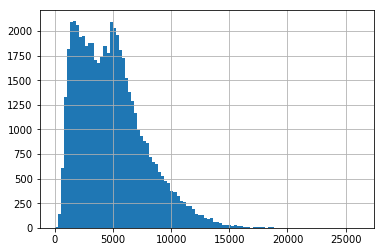

In [46]:
src['LENGHT'].hist(bins=100)

**WARNING** there are zero lenght items that should be filtered...

In [47]:
#Discarding too short and too long sounds
min_duration = 50 # in samples
max_duration = 16000
src = src[src.LENGHT>min_duration]
src = src[src.LENGHT<=max_duration]
print(f'Shortest item: {src.LENGHT.min()}')
print(f'Longest item: {src.LENGHT.max()}')
print(f'Number of items: {len(src)}')

Shortest item: 231
Longest item: 16000
Number of items: 54296


## Classify words

## Fine tune spectrogram

In [49]:
samples = src.sample(5,random_state=1)
ads = [AudioData(src.iloc[i].SIG,src.iloc[i].SR) for i in range(len(samples))]

In [56]:
for ad in ads:
    display(Image(tfm_spectro(ad)))

Specrogram should be configured properly: let's define a new function **tfm_spectro_tuned** with the parameters we wants, using partial application

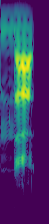

In [84]:
#n_mels = 128 should be ok
display(Image(tfm_spectro(ads[1],n_mels=128,to_db_scale=True))) #original
tfm_spectro_tuned = partial(tfm_spectro,n_mels=224, ws=200, n_fft=3200, to_db_scale=True)
display(Image(tfm_spectro_tuned(ads[1]))) #improved

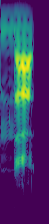

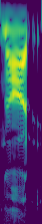

In [85]:
#Try with more examples...
for ad in ads:
    display(Image(tfm_spectro_tuned(ad)))

### DataBlock

In [60]:
#Create classes for all data!
classes = list(sorted(all_words_df.WRD.unique()))
len(classes), classes[:10]

(6102,
 ["'em",
  'a',
  'abbreviate',
  'abdomen',
  'abides',
  'ability',
  'able',
  'ably',
  'abolish',
  'aborigine'])

In [61]:
ils = AudioList.from_df(src, path, cols=['SampleAndSr'])

In [86]:
#Data Augmentation
tfms = get_audio_transforms(spectro=True,
                            mx_to_pad=max_duration, #1 sec window
                            white_noise=True,
                            modulate_volume=True,
                            random_cutout=False,
                            pad_with_silence=False,
                            pitch_warp=False,
                            down_and_up=False)

In [87]:
#Replace the spectrogram transform with tfm_spectro_stft
tfms[0][-1]=tfm_spectro_tuned
tfms[1][-1]=tfm_spectro_tuned
tfms

([functools.partial(<function tfm_add_white_noise at 0x7facee6c5d90>, noise_scl=0.005),
  functools.partial(<function tfm_modulate_volume at 0x7facee6c5e18>, lower_gain=0.1, upper_gain=1.2),
  functools.partial(<function tfm_pad_to_max at 0x7facee6d31e0>, mx=16000),
  functools.partial(<function tfm_spectro at 0x7faccdb71598>, n_mels=224, ws=200, n_fft=3200, to_db_scale=True)],
 [functools.partial(<function tfm_pad_to_max at 0x7facee6d31e0>, mx=16000),
  functools.partial(<function tfm_spectro at 0x7faccdb71598>, n_mels=224, ws=200, n_fft=3200, to_db_scale=True)])

In [88]:
data = (ils
        .split_from_df('is_valid')
        .label_from_df('WRD', classes=classes)
        .transform(tfms)
        .databunch(bs=64)) # NOTE: 

In [89]:
#Original sound (AudioData)
ils.get(99)

AudioItem REPRESENTATION

In [90]:
batch = data.one_batch()

In [91]:
#Shape of first X.
#Important: it's a spectrogram image:
#The original 1D sound is "augmented" and transformed into a 2D spectrogram
batch[0][0].shape

torch.Size([1, 224, 161])

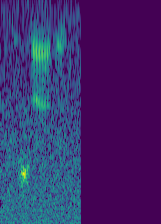

torch.Size([1, 224, 161])

'Corrisponding label: tensor([[[-59.2357, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],\n         [-58.2857, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],\n         [-58.3054, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],\n         ...,\n         [-62.8059, -59.4403, -59.6048,  ..., -80.0000, -80.0000, -80.0000],\n         [-69.3624, -71.3416, -54.0287,  ..., -80.0000, -80.0000, -80.0000],\n         [-55.1246, -69.4214, -62.5651,  ..., -80.0000, -80.0000, -80.0000]]])'

In [92]:
#Augmented sound transformed to spectrogram...
img=batch[0][0]
display(Image(img),img.shape,f'Corrisponding label: {batch[0][1]}')

**IMPORTANT**: as we see the phoneme is "paddded" with silence to the predefined value (max_duration)

In [93]:
#Take a look at the classes to ensure that are what we've setup
data.classes[:10]

["'em",
 'a',
 'abbreviate',
 'abdomen',
 'abides',
 'ability',
 'able',
 'ably',
 'abolish',
 'aborigine']

## Learner

In [94]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [95]:
def adapt_first_layer(src_model, nChannels):
    '''
    Change first layer of network to accomodate new channels
    '''
    # save original
    original_weights = src_model[0][0].weight.clone()
    new_weights = original_weights[:,0:1,:,:]

    # create new layes
    new_layer = nn.Conv2d(nChannels,64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    new_layer.weight = nn.Parameter(new_weights)

    # Replace layer and put to gpu.
    src_model[0][0] = new_layer
    src_model.cuda();

In [96]:
nChannels=1

# Alter existing model
adapt_first_layer(learn.model,nChannels)
print(f'First layer shape: {learn.model[0][0].weight.shape}')

First layer shape: torch.Size([64, 1, 7, 7])


## Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


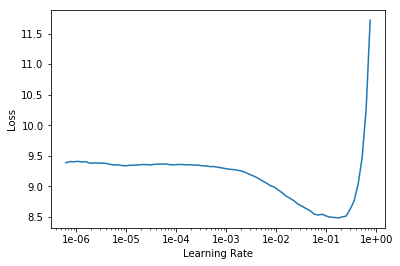

In [97]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,5.229638,6.012459,0.193999,03:21
1,4.375930,5.903974,0.266534,03:20
2,3.943572,6.366159,0.324616,03:21
3,3.682126,6.220423,0.350699,03:20
4,3.221303,6.029784,0.384213,03:20
5,2.842394,5.804327,0.419310,03:20
6,2.361724,5.706207,0.432868,03:20
7,2.077004,5.674556,0.437341,03:20


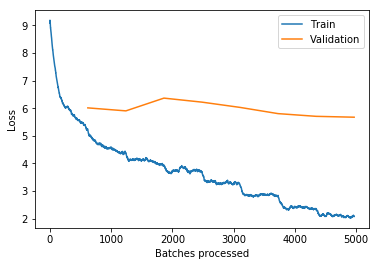

In [98]:
learn.fit_one_cycle(8, slice(2e-2))
learn.recorder.plot_losses()

In [100]:
learn.save('pass1_all')

In [101]:
learn.freeze_to(1)

epoch,train_loss,valid_loss,accuracy,time
0,2.285257,5.757097,0.433969,03:54
1,2.472304,5.756268,0.435345,03:54
2,2.378742,5.631007,0.443053,03:54
3,2.218575,5.635602,0.445393,03:54
4,2.088931,5.501657,0.474572,03:54
5,1.899984,5.499947,0.475053,03:54
6,1.676688,5.485618,0.483036,03:54
7,1.668107,5.497147,0.482348,03:54


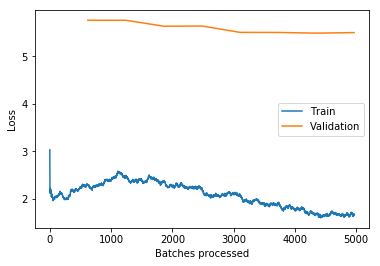

In [102]:
learn.fit_one_cycle(8, slice(1e-3))
learn.recorder.plot_losses()

In [104]:
learn.save('pass2_all')

In [105]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,1.838075,5.527787,0.474296,04:28
1,1.993158,5.582695,0.457505,04:28
2,2.059170,5.388886,0.483243,04:29
3,1.905824,5.417671,0.479114,04:28
4,1.747095,5.353645,0.495286,04:28
5,1.620091,5.335407,0.503407,04:28
6,1.413612,5.296753,0.508705,04:28
7,1.343631,5.283715,0.508293,04:28


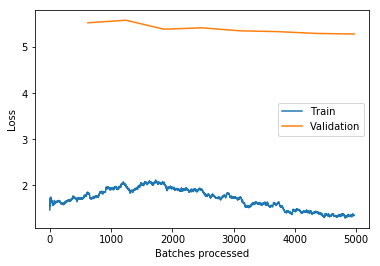

In [106]:
learn.fit_one_cycle(8, slice(1e-3))
learn.recorder.plot_losses()

In [ ]:
learn.save('pass3_all')

Not so good result: should work on it ;-)

## Fin.